In [15]:
import skchem
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
%matplotlib inline

#  Transforming

Operations on compounds are implemented as `Transformer`s in **scikit-chem**, which are analoguous to `Transformer` objects in **scikit-learn**.  These objects define a 1:1 mapping between input and output objects in a collection (i.e. the length of the collection remains the same during a transform).  These mappings can be very varied, but the three main types currently implemented in `scikit-chem` are `Standardizers`, `Forcefields` and `Featurizers`.

## Standardizers

Chemical data curation is a difficult concept, and data may be formatted differently depending on the source, or even the habits of the curator.  

For example, **solvents** or **salts** might be included the representation, which might be considered an unnecessary detail to a modeller, or even irrelevant to an experimentalist, if the compound is solvated is a standard solvent during the protocol.

Even the structure of molecules that would be considered the 'same', can often be drawn very differently.  For example,  [tautomers](https://en.wikipedia.org/wiki/Tautomers) are arguably the same molecule in different conditions, and [mesomers](https://en.wikipedia.org/wiki/Resonance) might be considered different aspects of the same molecule.  

Often, it is sensible to canonicalize these compounds in a process called **Standardization**.

In `scikit-chem`, the [standardizers](../api/skchem.standardizers.rst) package provides this functionality. `Standardizer` objects transform `Mol` objects into other `Mol` objects, which have their representation canonicalized (or into `None` if the protocol fails).  The details of the canonicalization may be configured at object initialization, or by altering properties.

As an example, we will standardize the sodium acetate:

In [3]:
mol = skchem.Mol.from_smiles('CC(=O)[O-].[Na+]', name='sodium acetate'); mol.to_smiles()

'CC(=O)[O-].[Na+]'

A `Standardizer` object is initialized:

In [43]:
std = skchem.standardizers.ChemAxonStandardizer()

Calling transform on sodium acetate yields the conjugate 'canonical' acid, acetic acid.

In [44]:
mol_std = std.transform(mol); mol_std.to_smiles()

'CC(=O)O'

The standardization of a collection of `Mol`s can be achieved by calling `transform` on a `pandas.Series`:

In [45]:
mols = skchem.read_smiles('https://archive.org/download/scikit-chem_example_files/example.smi', 
                          name_column=1); mols

name
ethane                          <Mol: CC>
propane                        <Mol: CCC>
benzene                   <Mol: c1ccccc1>
sodium acetate    <Mol: CC(=O)[O-].[Na+]>
serine                <Mol: NC(CO)C(=O)O>
Name: structure, dtype: object

In [46]:
std.transform(mols)

ChemAxonStandardizer: 100% (5 of 5) |##########################################| Elapsed Time: 0:00:01 Time: 0:00:01


name
ethane                      <Mol: CC>
propane                    <Mol: CCC>
benzene               <Mol: c1ccccc1>
sodium acetate         <Mol: CC(=O)O>
serine            <Mol: NC(CO)C(=O)O>
Name: structure, dtype: object

A loading bar is provided by default, although this can be disabled by lowering the verbosity:

In [47]:
std.verbose = 0
std.transform(mols)

name
ethane                      <Mol: CC>
propane                    <Mol: CCC>
benzene               <Mol: c1ccccc1>
sodium acetate         <Mol: CC(=O)O>
serine            <Mol: NC(CO)C(=O)O>
Name: structure, dtype: object

## Forcefields

Often the three dimensional structure of a compound is of relevance, but many chemical formats, such as [SMILES](http://www.daylight.com/dayhtml/doc/theory/theory.smiles.html) do not encode this information (and often even in formats which serialize geometry only coordinates in two dimensions are provided).

To produce a reasonable three dimensional **conformer**, a compound must be roughly embedded in three dimensions according to local geometrical constraints, and forcefields used to optimize the geometry of a compound.

In `scikit-chem`, the [forcefields](../api/skchem.forcefields.rst) package provides access to this functionality.  Two forcefields, the [Universal Force Field (UFF)](http://pubs.acs.org/doi/abs/10.1021/ja00051a040) and the <!--Markdown links can't have brackets, even if escaped --><a href="http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1096-987X(199604)17:5/6%3c490::AID-JCC1%3e3.0.CO%3b2-P/full">Merck Molecular Force Field (MMFF)</a> are currently provided.  We will use the UFF:

In [23]:
uff = skchem.forcefields.UFF()
mol = uff.transform(mol_std)

In [25]:
mol.atoms

<AtomView values="['C', 'C', 'O', 'O', 'H', 'H', 'H', 'H']" at 0x12102b6a0>

This uses the forcefield to generate a reasonable three dimensional structure.  In `rdkit` (and thus `scikit-chem`, conformers are separate entities). The forcefield creates a new conformer on the object:

In [27]:
mol.conformers[0].atom_positions

[<Point3D coords="(1.22, -0.48, 0.10)" at 0x1214de3d8>,
 <Point3D coords="(0.00, 0.10, -0.54)" at 0x1214de098>,
 <Point3D coords="(0.06, 1.22, -1.11)" at 0x1214de168>,
 <Point3D coords="(-1.20, -0.60, -0.53)" at 0x1214de100>,
 <Point3D coords="(1.02, -0.64, 1.18)" at 0x1214de238>,
 <Point3D coords="(1.47, -1.45, -0.37)" at 0x1214de1d0>,
 <Point3D coords="(2.08, 0.21, -0.00)" at 0x1214de2a0>,
 <Point3D coords="(-1.27, -1.51, -0.08)" at 0x1214de308>]

The molecule can be visualized by drawing it:

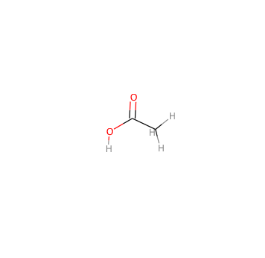

In [35]:
skchem.vis.draw(mol)

## Featurizers (fingerprint and descriptor generators)

Chemical representation is not by itself very amenable to data analysis and mining techniques.  Often, a fixed length vector representation is required.  This is achieved by calculating **features** from the chemical representation.

In **scikit-chem**, this is provided by the `descriptors` package.  A selection of features are available:

In [11]:
skchem.descriptors.__all__

['PhysicochemicalFeaturizer',
 'AtomFeaturizer',
 'AtomPairFeaturizer',
 'MorganFeaturizer',
 'MACCSFeaturizer',
 'TopologicalTorsionFeaturizer',
 'RDKFeaturizer',
 'ErGFeaturizer',
 'ConnectivityInvariantsFeaturizer',
 'FeatureInvariantsFeaturizer',
 'ChemAxonNMRPredictor',
 'ChemAxonFeaturizer',
 'ChemAxonAtomFeaturizer',
 'GraphDistanceTransformer',
 'SpacialDistanceTransformer']

[Circular fingerprints](http://www.ncbi.nlm.nih.gov/pubmed/16523386) (of which Morgan fingerprints are an example) are often considered the most consistently well performing descriptor across a wide variety of compounds.

In [12]:
mf = skchem.descriptors.MorganFeaturizer()
mf.transform(mol)

morgan_fp_idx
0       0
1       0
2       0
3       0
4       0
       ..
2043    0
2044    0
2045    0
2046    0
2047    0
Name: MorganFeaturizer, dtype: uint8

We can also call the standardizer on a series of `Mol`s:

In [13]:
mf.transform(mols.structure)

MorganFeaturizer: 100% (5 of 5) |##############################################| Elapsed Time: 0:00:00 Time: 0:00:00


morgan_fp_idx,0,1,2,3,4,...,2043,2044,2045,2046,2047
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,1,0,0,0,...,0,0,0,0,0
